<a href="https://colab.research.google.com/github/Lucky-Millare/CSST106-CS4B/blob/main/4B-MILLARE-MP4/4B-MILLARE-MP4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# Uninstall existing OpenCV packages
!pip uninstall -y opencv-python opencv-contrib-python opencv-python-headless

# Install system dependencies
!apt-get update
!apt-get install -y build-essential cmake git pkg-config libjpeg-dev libtiff5-dev \
    libjasper-dev libpng-dev libavcodec-dev libavformat-dev libswscale-dev \
    libv4l-dev libxvidcore-dev libx264-dev libgtk-3-dev libatlas-base-dev gfortran \
    python3-dev

# Clone OpenCV and OpenCV contrib
!git clone https://github.com/opencv/opencv.git
!git clone https://github.com/opencv/opencv_contrib.git

# Create a build directory
!mkdir -p opencv/build
%cd opencv/build

# Configure the build with non-free modules
!cmake -DOPENCV_EXTRA_MODULES_PATH=../../opencv_contrib/modules -DOPENCV_ENABLE_NONFREE=ON -D CMAKE_BUILD_TYPE=RELEASE -D CMAKE_INSTALL_PREFIX=/usr/local ..

# Build OpenCV (this may take some time)
!make -j4

# Install the built OpenCV
!make install

Found existing installation: opencv-python 4.10.0.84
Uninstalling opencv-python-4.10.0.84:
  Successfully uninstalled opencv-python-4.10.0.84
Found existing installation: opencv-contrib-python 4.10.0.84
Uninstalling opencv-contrib-python-4.10.0.84:
  Successfully uninstalled opencv-contrib-python-4.10.0.84
Found existing installation: opencv-python-headless 4.10.0.84
Uninstalling opencv-python-headless-4.10.0.84:
  Successfully uninstalled opencv-python-headless-4.10.0.84
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 htt

# **Import Libraries**

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Task 1: Harris Corner Detection

### Load the Image in Grayscale, and Convert to Float

In [3]:
image_path = '/content/drive/MyDrive/image.jpeg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
gray = np.float32(image)

### Apply Harris corner detection

In [4]:
dst = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)

### Threshold for an optimal value and Mark corners in Red

In [5]:
image[dst > 0.01 * dst.max()] = 255
image_with_corners = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
image_with_corners[dst > 0.01 * dst.max()] = [0, 0, 255]

### Display the Image

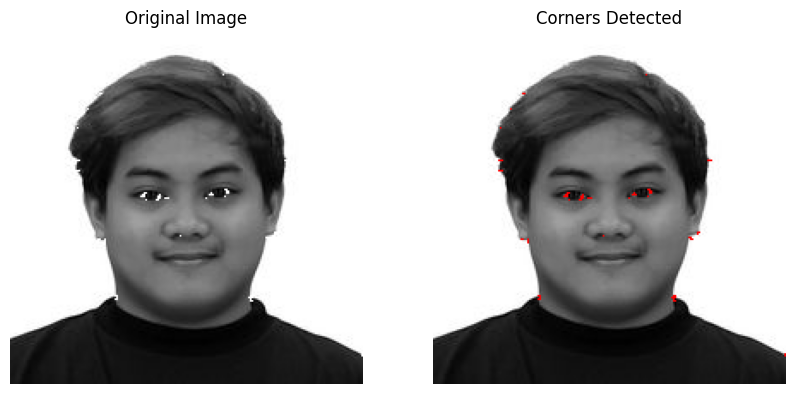

In [6]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_with_corners, cv2.COLOR_BGR2RGB))
plt.title('Corners Detected')
plt.axis('off')
plt.show()

# **Task 2: HOG Feature Extraction**

### Load Image and Convert to Grayscale

In [7]:
image_path = '/content/drive/MyDrive/image.jpeg'
image = cv2.imread(image_path)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

### Compute HOG features and visualization

In [8]:
fd, hog_image = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True,
                    channel_axis=None)

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

### Display the Image

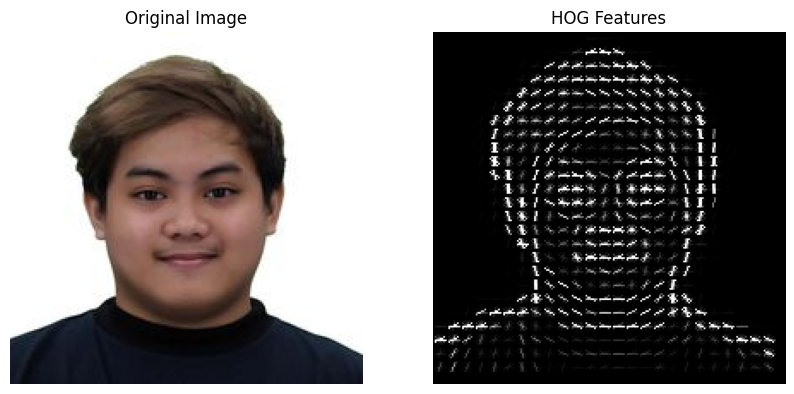

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(hog_image_rescaled, cmap='gray')
plt.title('HOG Features')
plt.axis('off')

plt.show()

# **Task 3: ORB Feature Extraction and Matching**

Load the Image and Convert to Grayscale

In [10]:
image1_path = '/content/drive/MyDrive/image.jpeg'
image2_path = '/content/drive/MyDrive/image.jpeg'

image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)

gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

### Initiate ORB detector

In [11]:
orb = cv2.ORB_create()

### Keypoints and Descriptors for ORB

In [12]:
keypoints_orb1, descriptors_orb1 = orb.detectAndCompute(gray1, None)
keypoints_orb2, descriptors_orb2 = orb.detectAndCompute(gray2, None)

### FLANN parameters

In [13]:
FLANN_INDEX_LSH = 6
index_params = dict(algorithm=FLANN_INDEX_LSH,
                      table_number=6,  # 12
                      key_size=12,     # 20
                      multi_probe_level=1)  # 2
search_params = dict(checks=50)

### FLANN-based matcher object

In [14]:
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Match descriptors
matches = flann.knnMatch(descriptors_orb1, descriptors_orb2, k=2)

# Store all the good matches as per Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# Draw matches
img_matches = cv2.drawMatches(image1, keypoints_orb1, image2, keypoints_orb2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

### Display the Image

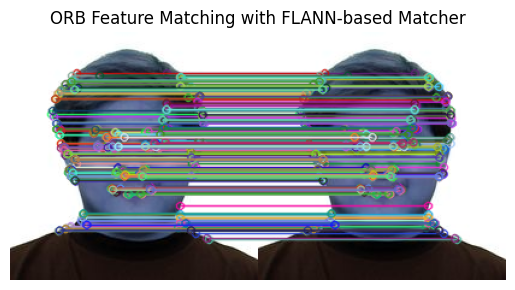

In [15]:
plt.imshow(img_matches)
plt.axis('off')
plt.title('ORB Feature Matching with FLANN-based Matcher')
plt.show()

# **Task 4: SIFT and SURF Feature Extraction**

### Load the Image and Convert to Grayscale

In [5]:
image1_path = '/content/drive/MyDrive/image.jpeg'
image2_path = '/content/drive/MyDrive/image.jpeg'

image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)

gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

### Initialize SIFT and SURF detectors

In [3]:
sift = cv2.SIFT_create()
surf = cv2.xfeatures2d.SURF_create()

### Keypoints and descriptors for SIFT and SURF

In [6]:
keypoints_sift1, descriptors_sift1 = sift.detectAndCompute(gray1, None)
keypoints_sift2, descriptors_sift2 = sift.detectAndCompute(gray2, None)

keypoints_surf1, descriptors_surf1 = surf.detectAndCompute(gray1, None)
keypoints_surf2, descriptors_surf2 = surf.detectAndCompute(gray2, None)

### Draw keypoints on the images

In [7]:
image1_sift = cv2.drawKeypoints(image1, keypoints_sift1, None)
image2_sift = cv2.drawKeypoints(image2, keypoints_sift2, None)

image1_surf = cv2.drawKeypoints(image1, keypoints_surf1, None)
image2_surf = cv2.drawKeypoints(image2, keypoints_surf2, None)

### Display the Image

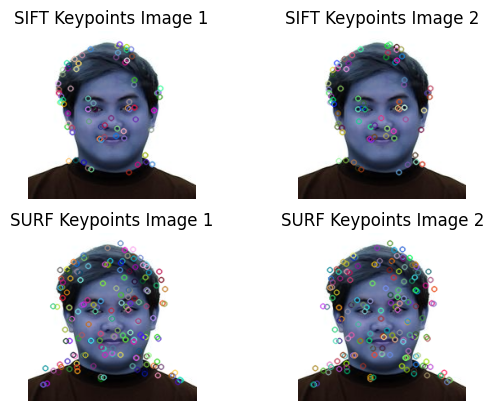

In [8]:
plt.subplot(2, 2, 1)
plt.imshow(image1_sift)
plt.title('SIFT Keypoints Image 1')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(image2_sift)
plt.title('SIFT Keypoints Image 2')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(image1_surf)
plt.title('SURF Keypoints Image 1')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(image2_surf)
plt.title('SURF Keypoints Image 2')
plt.axis('off')

plt.show()

# **Task 5: Feature Matching using Brute-Force Matcher**

### Load the Image and Convert to grayscale

In [21]:
image1_path = '/content/drive/MyDrive/image.jpeg'
image2_path = '/content/drive/MyDrive/image.jpeg'

image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)

gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

### Initialize ORB detector

In [22]:
orb = cv2.ORB_create()

### Keypoints and descriptors for ORB

In [23]:
keypoints_orb1, descriptors_orb1 = orb.detectAndCompute(gray1, None)
keypoints_orb2, descriptors_orb2 = orb.detectAndCompute(gray2, None)

### Create BFMatcher object

In [24]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(descriptors_orb1, descriptors_orb2)

# Sort them in the order of their distance
matches = sorted(matches, key=lambda x: x.distance)

# Draw first 10 matches
img_matches = cv2.drawMatches(image1, keypoints_orb1, image2, keypoints_orb2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

### Display the Image

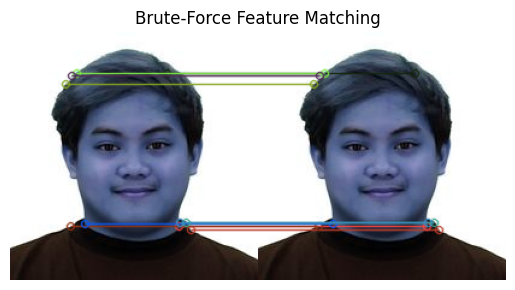

In [37]:
plt.imshow(img_matches)
plt.title('Brute-Force Feature Matching')
plt.axis('off')
plt.show()

# **Task 6: Image Segmentation using Watershed Algorithm**

### Load the Image and Convert to Grayscale

In [26]:
image_path = '/content/drive/MyDrive/image.jpeg'
image = cv2.imread(image_path)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

### Apply a threshold to get binary image

In [27]:
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

### Noise removal using morphological operations

In [28]:
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

### Sure background area, Finding sure foreground area, and Finding unknown region

In [29]:
sure_bg = cv2.dilate(opening, kernel, iterations=3)

dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

### Marker labeling

In [30]:
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# Now, mark the region of unknown with zero
markers[unknown == 255] = 0

 ### Apply the Watershed algorithm

In [31]:
markers = cv2.watershed(image, markers)
image[markers == -1] = [255, 0, 0]

### Display the Image

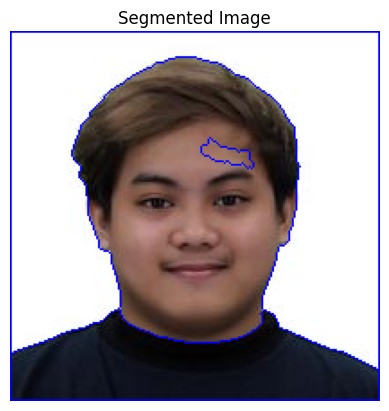

In [38]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Segmented Image')
plt.axis('off')
plt.show()